In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from models.Clustering import Clustering

plt.style.use('ggplot')

In [4]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"

## Load memory data - FREDMD

In [5]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

In [2]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI              0.032678 -0.047984  0.000752 -0.025343  0.063781 -0.045892   
W875RX1         -0.112550 -0.068211 -0.038119  0.032999  0.006149  0.006541   
DPCERA3M086SBEA -0.146550  0.027131 -0.060616  0.042417 -0.018647 -0.143320   
CMRMTSPLx       -0.135673 -0.008126 -0.053135  0.014012  0.024570 -0.093309   
RETAILx         -0.127633  0.065554 -0.019088  0.035344  0.000766 -0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx        -0.037855  0.012142 -0.030014 -0.014400 -0.012411 -0.098975   
DTCOLNVHFNM     -0.002451  0.009939  0.011267 -0.016205 -0.015283 -0.058104   
DTCTHFNM        -0.006255  0.013653  0.012419 -0.018355 -0.013001 -0.032122   
INVEST          -0.015517  0.016652 -0.007961  0.011221 -0.015233  0.019285   
VIXCLSx          0.052323  0.001555  0.009238  0.039914 -0.001340 -0.121704   

                      PC6       PC7       PC8      

## Run Kmeans with euclidean + cosine distances as the input of each pass

In [3]:
clustering_method = 'kmeans'
k_opt_method = 'elbow'
k = 5

low_pass_clustering = Clustering(similarity_method='euclidean')
clustering = Clustering(similarity_method='cosine')

# subset train data
train = memory_data.copy()

# compute clusters for easy days
low_pass_k = 2
cutoff_date = pd.Timestamp('2020-03-01')
#ßcutoff_date = pd.Timestamp('2021-06-01')
#cutoff_date = pd.Timestamp('2021-11-01')
if train.index.to_list()[-1] > cutoff_date:
    low_pass_k = 3
knn_clusters, knn_euc_clusters, knn_euc_probs = low_pass_clustering.compute_clusters(data=train, extra_data=train, method=clustering_method, k=low_pass_k, k_opt_method=k_opt_method)

# find the cluster with the most observations and set as "hard days"
train["cluster"] = knn_clusters
cluster_sizes = []
for i in range(low_pass_k):
    temp = train.loc[:, "cluster"] == i
    temp = temp[temp == True]
    cluster_sizes.append(len(temp))
knn_largest_cluster = np.argmax(cluster_sizes)

## subset train data
knn_train_hard = train[train.loc[:, "cluster"] == knn_largest_cluster].copy()
knn_train_easy = train[train.loc[:, "cluster"] != knn_largest_cluster].copy()
temp = []
for i in range(low_pass_k):
    if i == knn_largest_cluster:
        temp.insert(0, knn_euc_clusters[i])
    else:
        temp.append(knn_euc_clusters[i])
knn_euc_clusters = np.array(temp)
knn_euc_probs = np.concatenate([knn_euc_probs[:, knn_largest_cluster].reshape(-1, 1), np.delete(knn_euc_probs, knn_largest_cluster, axis=1)], axis=1)

# compute clusters for hard days
knn_clusters, knn_hard_centroids, knn_hard_probs = clustering.compute_clusters(data=knn_train_hard, extra_data=train, method=clustering_method, k=k)

knn_train_easy["cluster"] = 0
knn_train_hard["cluster"] = knn_clusters + 1
# merge easy and hard clusters
knn_train = pd.concat([knn_train_easy, knn_train_hard]).sort_index()

In [4]:
knn_euc_probs

array([[0.45057642, 0.06244123, 0.48698235],
       [0.44566525, 0.06598187, 0.48835288],
       [0.45227467, 0.06156823, 0.4861571 ],
       ...,
       [0.49430943, 0.0557702 , 0.44992037],
       [0.4935614 , 0.05977954, 0.44665906],
       [0.4941197 , 0.05598556, 0.44989474]])

In [5]:
knn_hard_probs

array([[0.20309916, 0.19683608, 0.19261497, 0.19668725, 0.21076253],
       [0.20929537, 0.19895399, 0.19173433, 0.18987548, 0.21014084],
       [0.20102983, 0.19635486, 0.19210041, 0.19593443, 0.21458048],
       ...,
       [0.18881832, 0.20528266, 0.21452425, 0.19268935, 0.19868543],
       [0.19007402, 0.20039408, 0.21120554, 0.20431409, 0.19401226],
       [0.18489771, 0.20242173, 0.21510761, 0.20410508, 0.19346787]])

## Run GMM in Kmeans place

In [6]:
clustering_method = 'gmm'
k_opt_method = 'elbow'
k = 5

low_pass_clustering = Clustering(similarity_method='euclidean')
clustering = Clustering(similarity_method='cosine')

# subset train data
train = memory_data.copy()

# compute clusters for easy days
low_pass_k = 2
cutoff_date = pd.Timestamp('2020-03-01')
#cutoff_date = pd.Timestamp('2021-06-01')
#cutoff_date = pd.Timestamp('2021-11-01')
if train.index.to_list()[-1] > cutoff_date:
    low_pass_k = 3
gmm_clusters, gmm_euc_clusters, gmm_euc_probs = low_pass_clustering.compute_clusters(data=train, extra_data=train, method=clustering_method, k=low_pass_k, k_opt_method=k_opt_method)

# find the cluster with the most observations and set as "hard days"
train["cluster"] = gmm_clusters
cluster_sizes = []
for i in range(low_pass_k):
    temp = train.loc[:, "cluster"] == i
    temp = temp[temp == True]
    cluster_sizes.append(len(temp))
gmm_largest_cluster = np.argmax(cluster_sizes)

## subset train data
gmm_train_hard = train[train.loc[:, "cluster"] == gmm_largest_cluster].copy()
gmm_train_easy = train[train.loc[:, "cluster"] != gmm_largest_cluster].copy()
temp = []
for i in range(low_pass_k):
    if i == gmm_largest_cluster:
        temp.insert(0, gmm_euc_clusters[i])
    else:
        temp.append(gmm_euc_clusters[i])
gmm_euc_clusters = np.array(temp)
gmm_euc_probs = np.concatenate([gmm_euc_probs[:, gmm_largest_cluster].reshape(-1, 1), np.delete(gmm_euc_probs, gmm_largest_cluster, axis=1)], axis=1)

# compute clusters for hard days
gmm_clusters, gmm_hard_centroids, gmm_hard_probs = clustering.compute_clusters(data=gmm_train_hard, extra_data=train, method=clustering_method, k=k)

gmm_train_easy["cluster"] = 0
gmm_train_hard["cluster"] = gmm_clusters + 1
# merge easy and hard clusters
gmm_train = pd.concat([gmm_train_easy, gmm_train_hard]).sort_index()

In [7]:
gmm_euc_probs

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [8]:
gmm_hard_probs

array([[1.83927020e-185, 0.00000000e+000, 1.00000000e+000,
        3.85573849e-215, 0.00000000e+000],
       [3.94062122e-198, 0.00000000e+000, 1.00000000e+000,
        1.91673186e-249, 3.91208727e-300],
       [4.26839621e-179, 0.00000000e+000, 1.00000000e+000,
        2.40187030e-232, 0.00000000e+000],
       ...,
       [2.98169016e-038, 1.00000000e+000, 2.54805162e-043,
        1.18211360e-018, 8.01511993e-022],
       [1.16565070e-023, 1.00000000e+000, 1.43103715e-019,
        1.65469218e-017, 5.22172981e-022],
       [3.14763693e-040, 2.42020002e-012, 1.69155122e-019,
        2.24812414e-020, 1.00000000e+000]])

## Compare clusters

In [76]:
melt_X = knn_train[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
kmeans_pivot_X = pivot_X.copy()
kmeans_pivot_X.columns = kmeans_pivot_X.columns.droplevel()

melt_X = gmm_train[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
gmm_pivot_X = pivot_X.copy()
gmm_pivot_X.columns = gmm_pivot_X.columns.droplevel()

In [77]:
def swap_columns(df, col1, col2):
    n_df = df.replace(col1, -1).replace(col2, col1).replace(-1, col2).copy()
    n_df[col1], n_df[col2] = n_df[col2], n_df[col1]
    return n_df

gmm_pivot_X = swap_columns(gmm_pivot_X.copy(), 5, 1)
gmm_pivot_X = swap_columns(gmm_pivot_X.copy(), 2, 4)
gmm_pivot_X = swap_columns(gmm_pivot_X.copy(), 3, 1)
gmm_pivot_X = swap_columns(gmm_pivot_X.copy(), 3, 2)

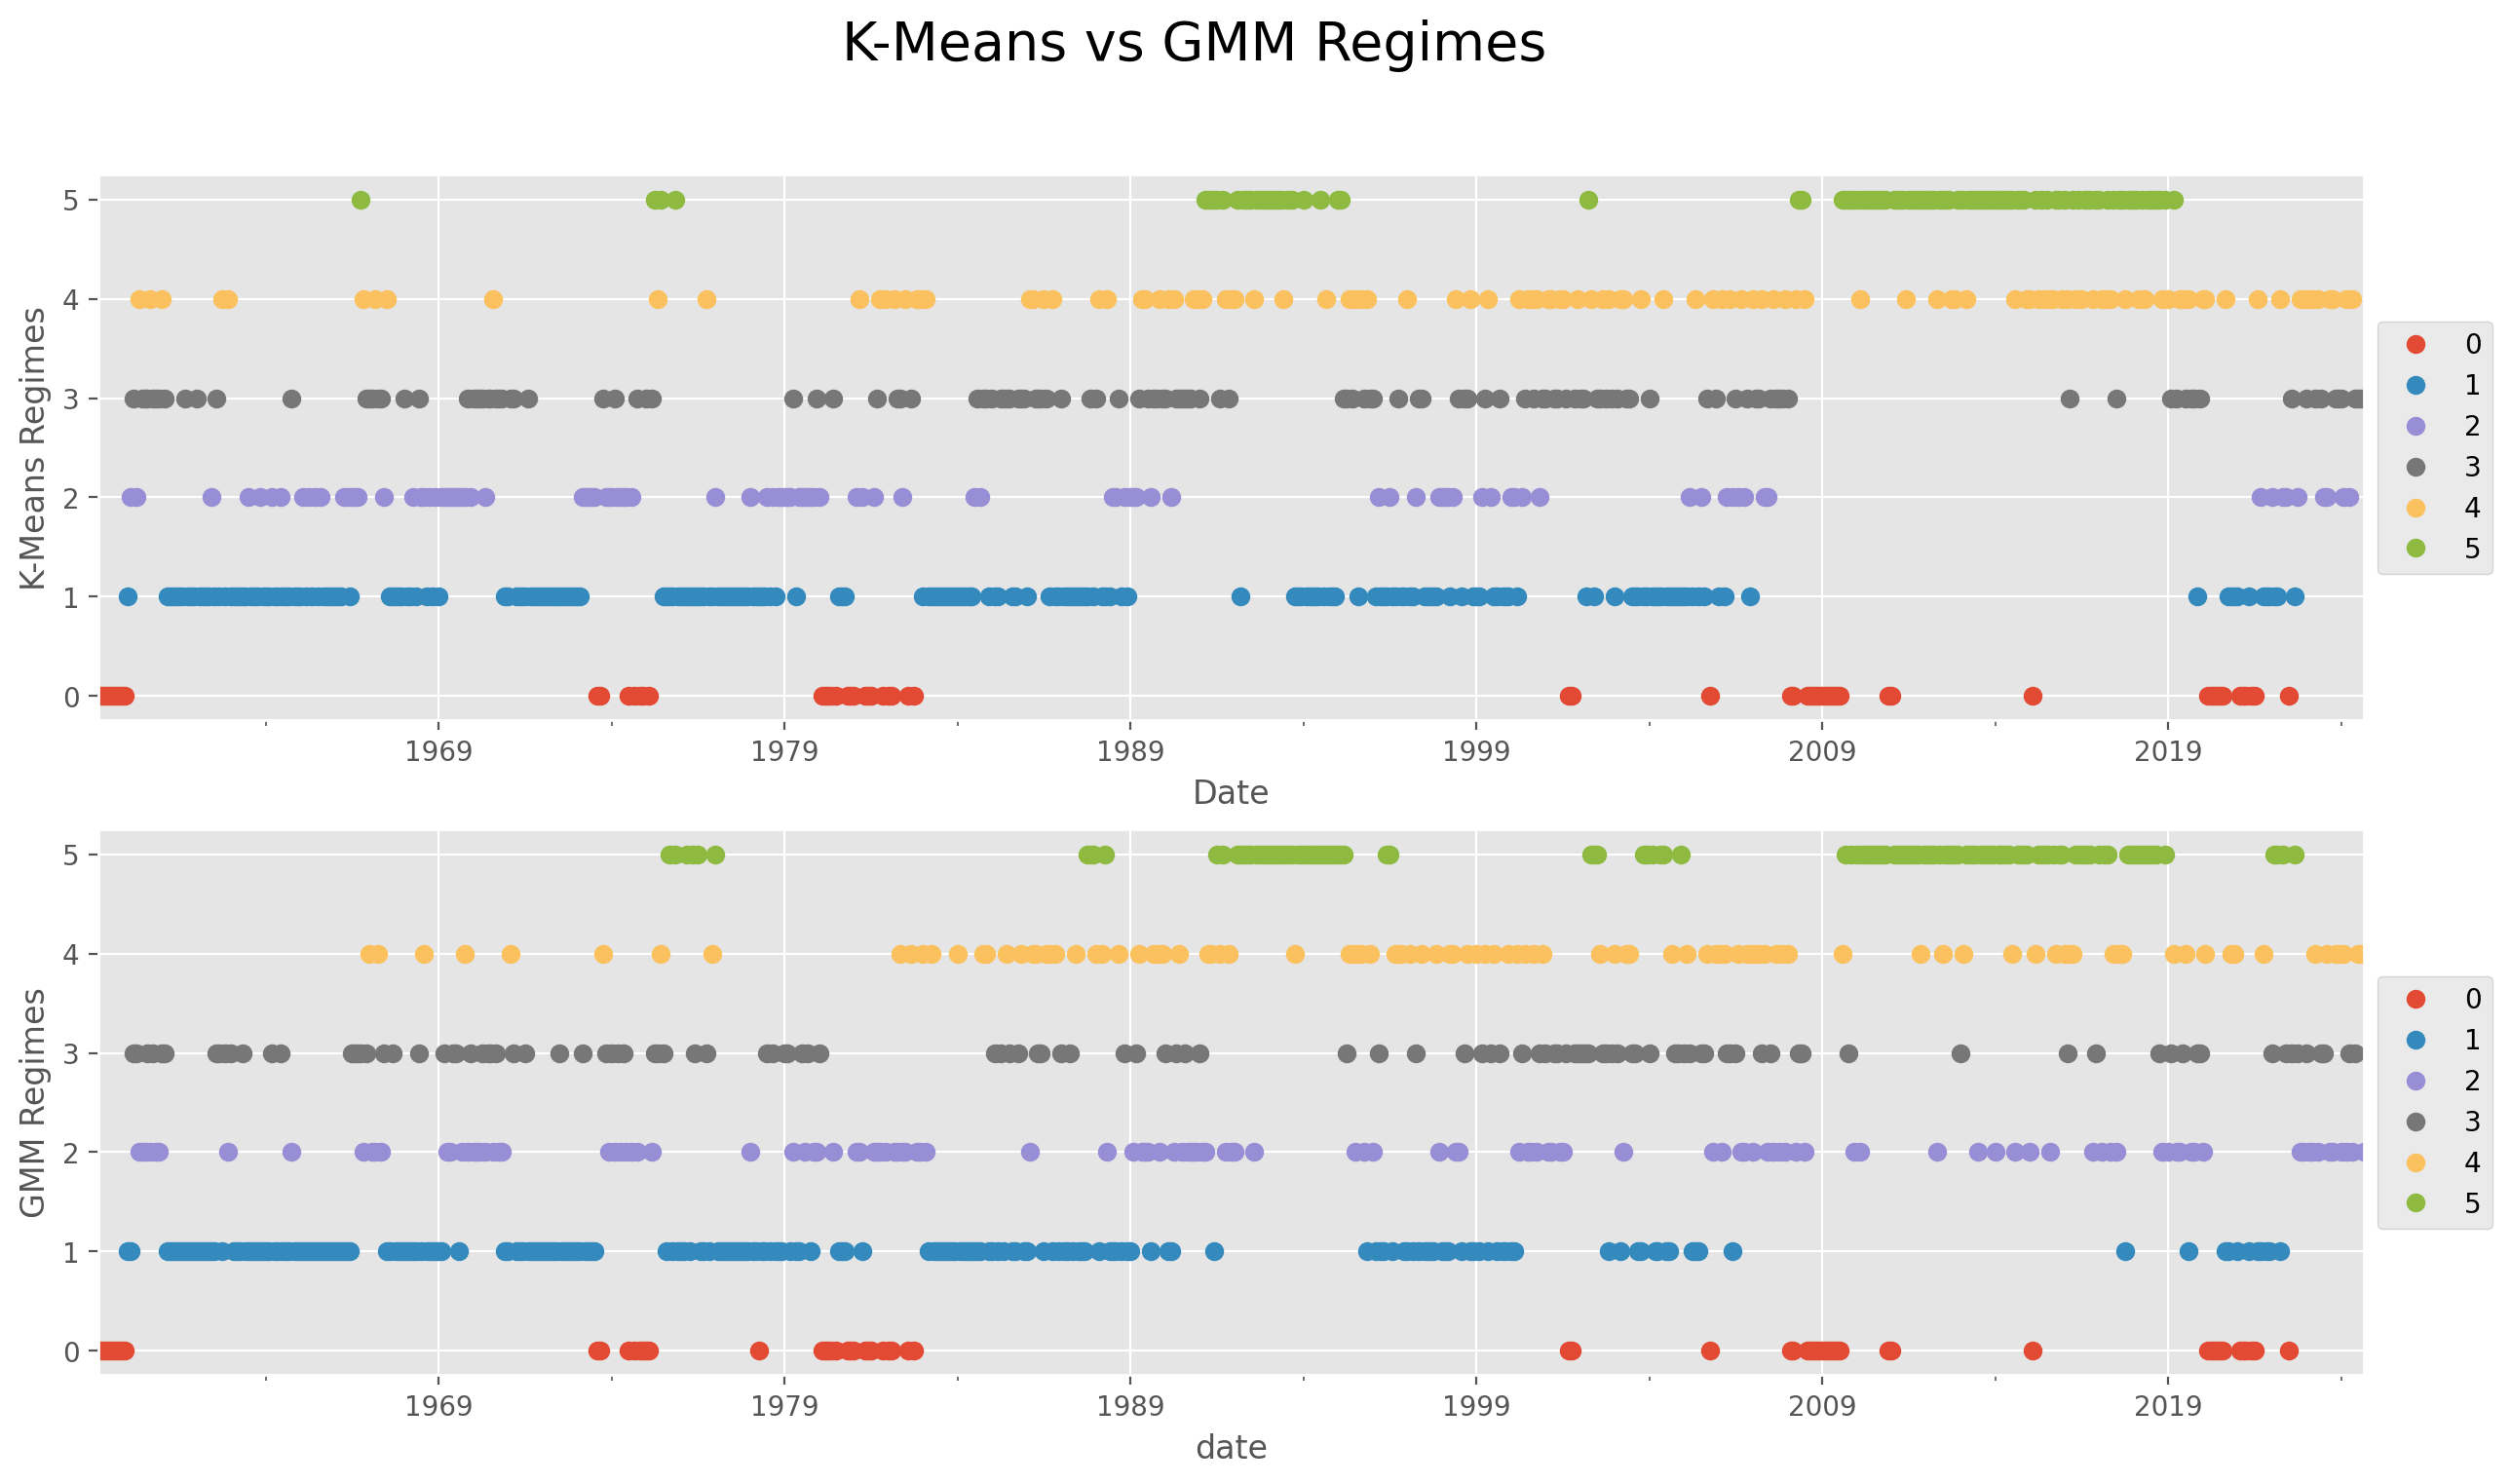

In [83]:
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(2, 1, figsize=(15, 8))


# add title
fig.suptitle("K-Means vs GMM Regimes", fontsize=20)
kmeans_pivot_X[[v for v in range(6)]].plot(ax=axs[0], marker="o", linestyle="")

axs[0].set_xlabel("Date")
axs[0].set_ylabel("K-Means Regimes")
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

gmm_pivot_X[[v for v in range(6)]].plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Regimes")
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Compare probabilities

In [102]:
knn_euc_probs_df = pd.DataFrame(knn_euc_probs, index=train.index)
gmm_euc_probs_df = pd.DataFrame(gmm_euc_probs, train.index)

knn_hard_probs_df = pd.DataFrame(knn_hard_probs, train.index)
gmm_hard_probs_df = pd.DataFrame(gmm_hard_probs, train.index)

In [103]:
knn_euc_probs_df[1] = knn_euc_probs_df[[1, 2]].max(axis=1)
knn_euc_probs_df = knn_euc_probs_df.drop(2, axis=1)

gmm_euc_probs_df[1] = gmm_euc_probs_df[[1, 2]].max(axis=1)
gmm_euc_probs_df = gmm_euc_probs_df.drop(2, axis=1)

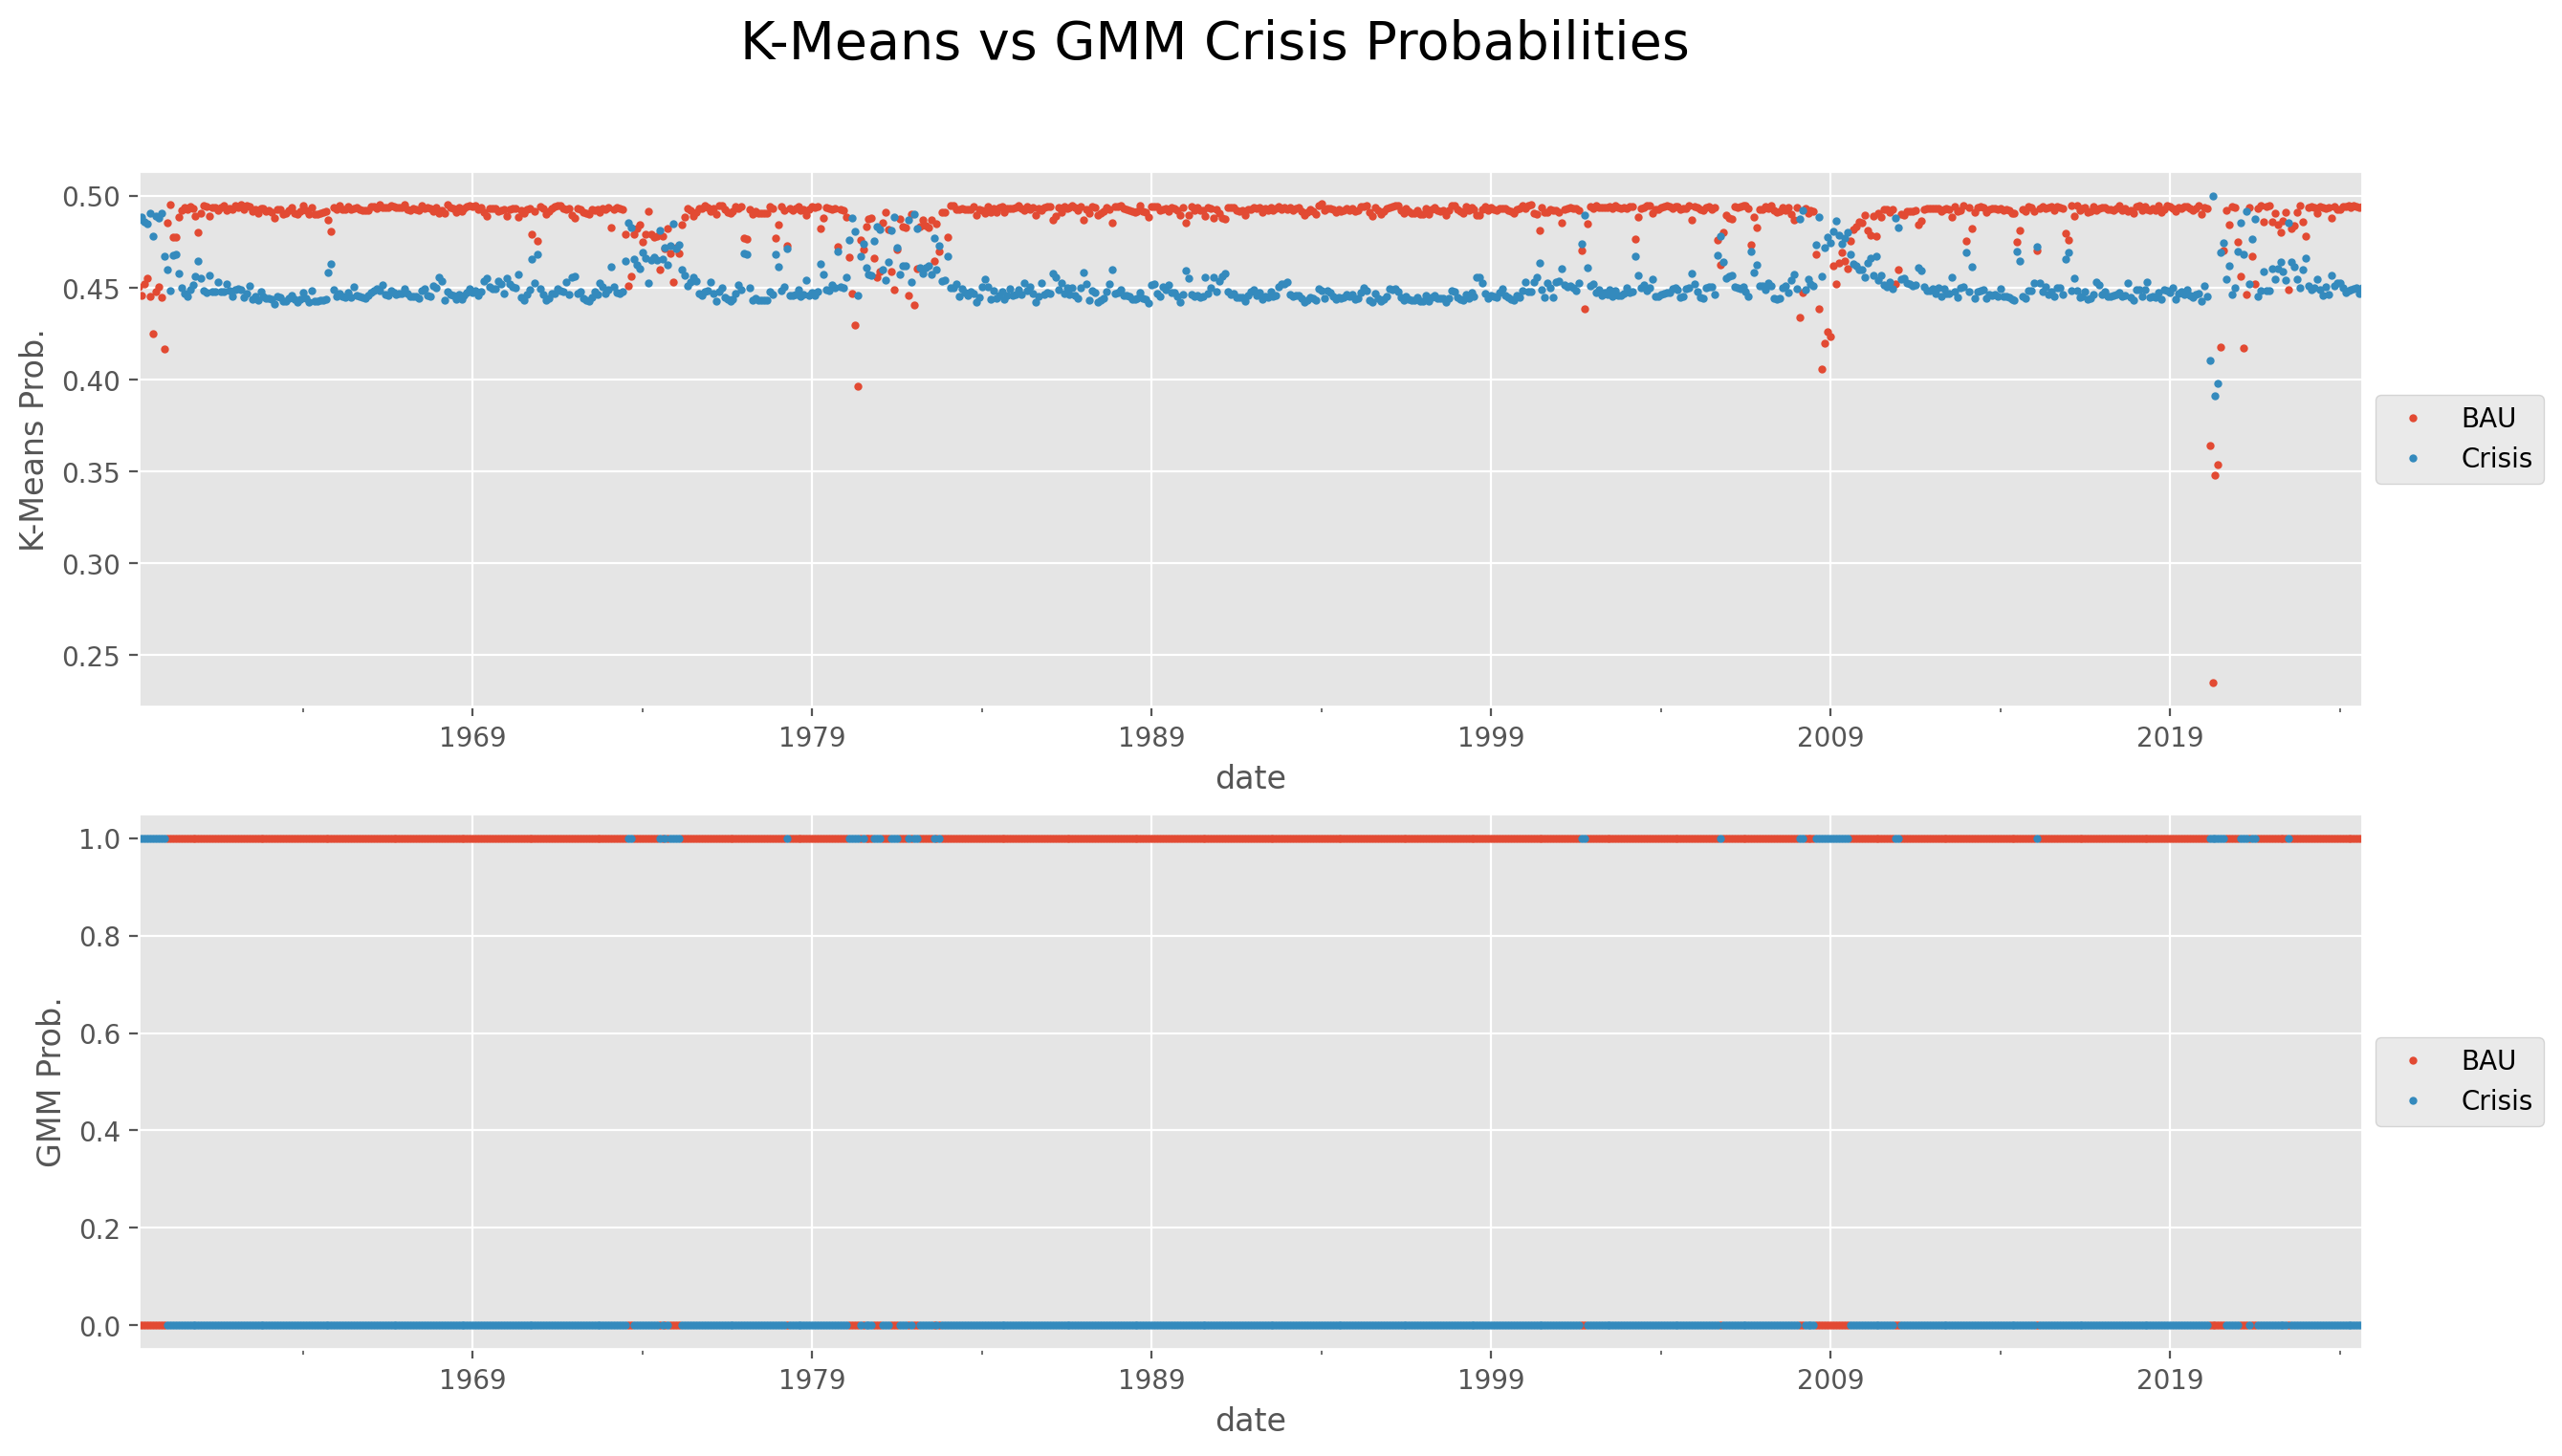

In [109]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("K-Means vs GMM Crisis Probabilities", fontsize=20)
knn_euc_probs_df.plot(ax=axs[0], marker="o", linestyle="", markersize=2)
axs[0].set_xlabel("date")
axs[0].set_ylabel("K-Means Prob.")
axs[0].legend(['BAU', 'Crisis'], loc='center left', bbox_to_anchor=(1, 0.5))

gmm_euc_probs_df.plot(ax=axs[1], marker="o", linestyle="", markersize=2)
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Prob.")
axs[1].legend(['BAU', 'Crisis'], loc='center left', bbox_to_anchor=(1, 0.5))

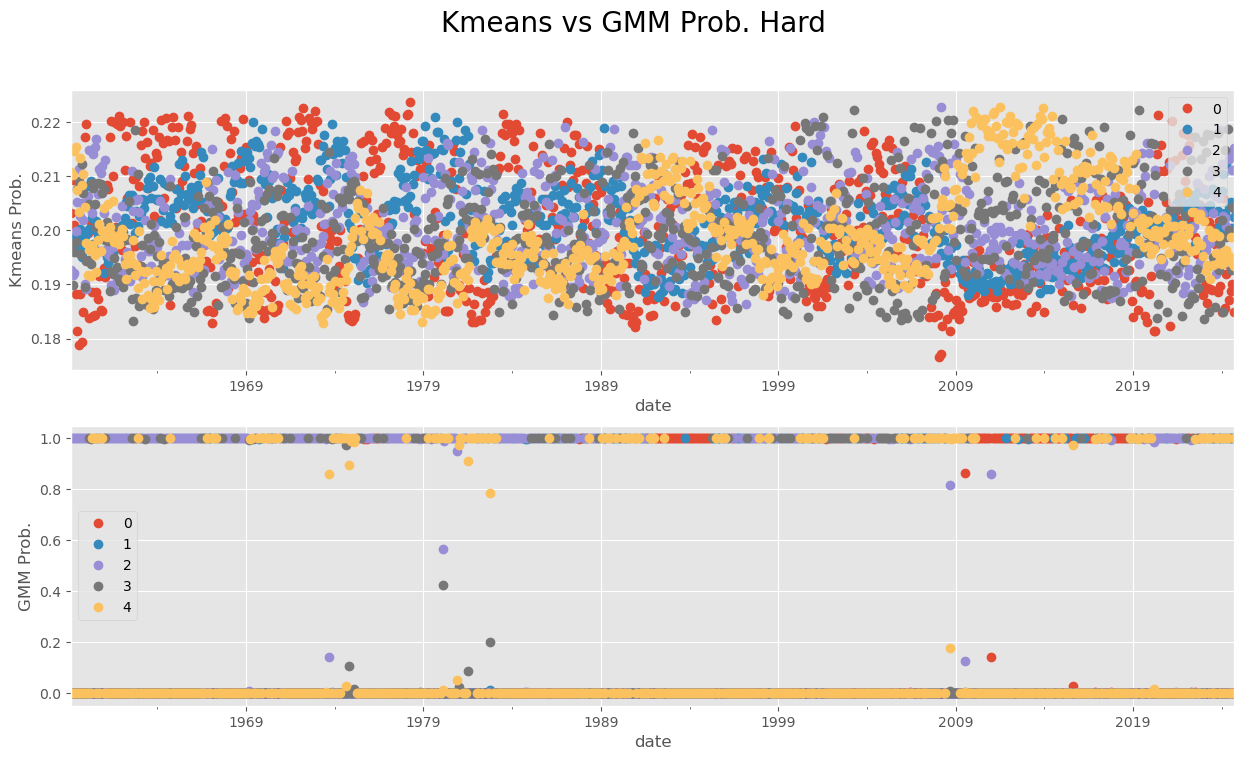

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("Kmeans vs GMM Prob. Hard", fontsize=20)
knn_hard_probs_df.plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Kmeans Prob.")
axs[0].legend()

gmm_hard_probs_df.plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Prob.")
axs[1].legend()

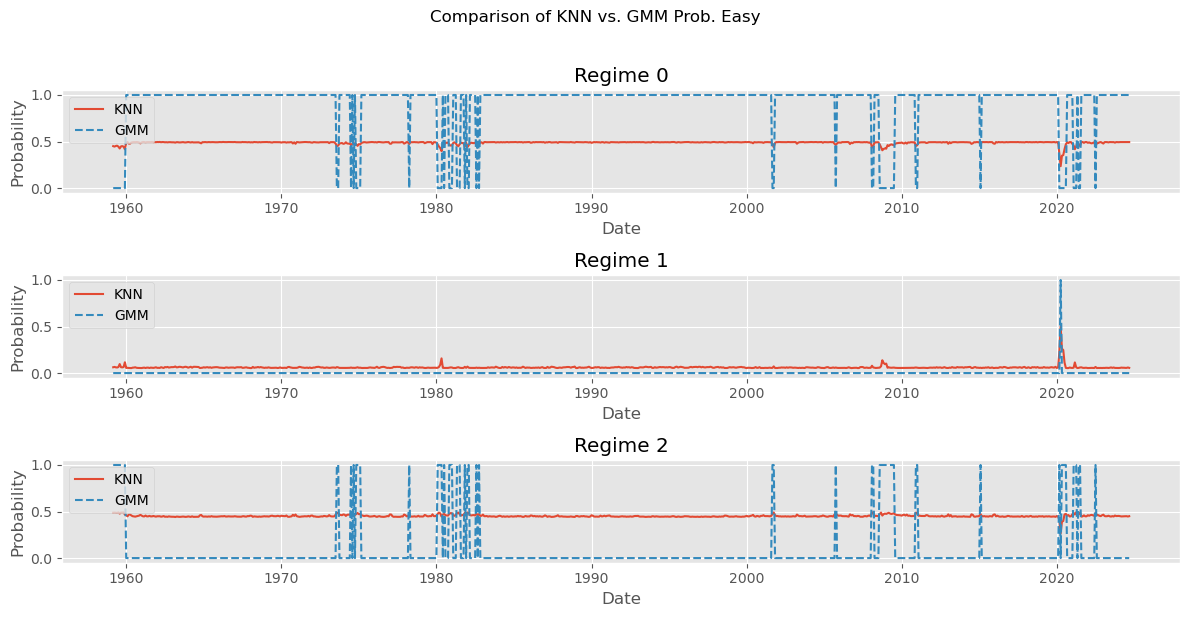

In [14]:
# Set the figure size and number of subplots for EUC probabilities comparison
fig, axes = plt.subplots(len(knn_euc_probs_df.columns), 1, figsize=(12, 2 * len(knn_euc_probs_df.columns)))
fig.suptitle("Comparison of KNN vs. GMM Prob. Easy", y=1.02)

for i, feature in enumerate(knn_euc_probs_df.columns):
    ax = axes[i]
    ax.plot(knn_euc_probs_df.index, knn_euc_probs_df[feature], label="KNN")
    ax.plot(gmm_euc_probs_df.index, gmm_euc_probs_df[feature], label="GMM", linestyle="--")
    ax.set_title(f"Regime {feature}")
    ax.legend(loc="upper left")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()

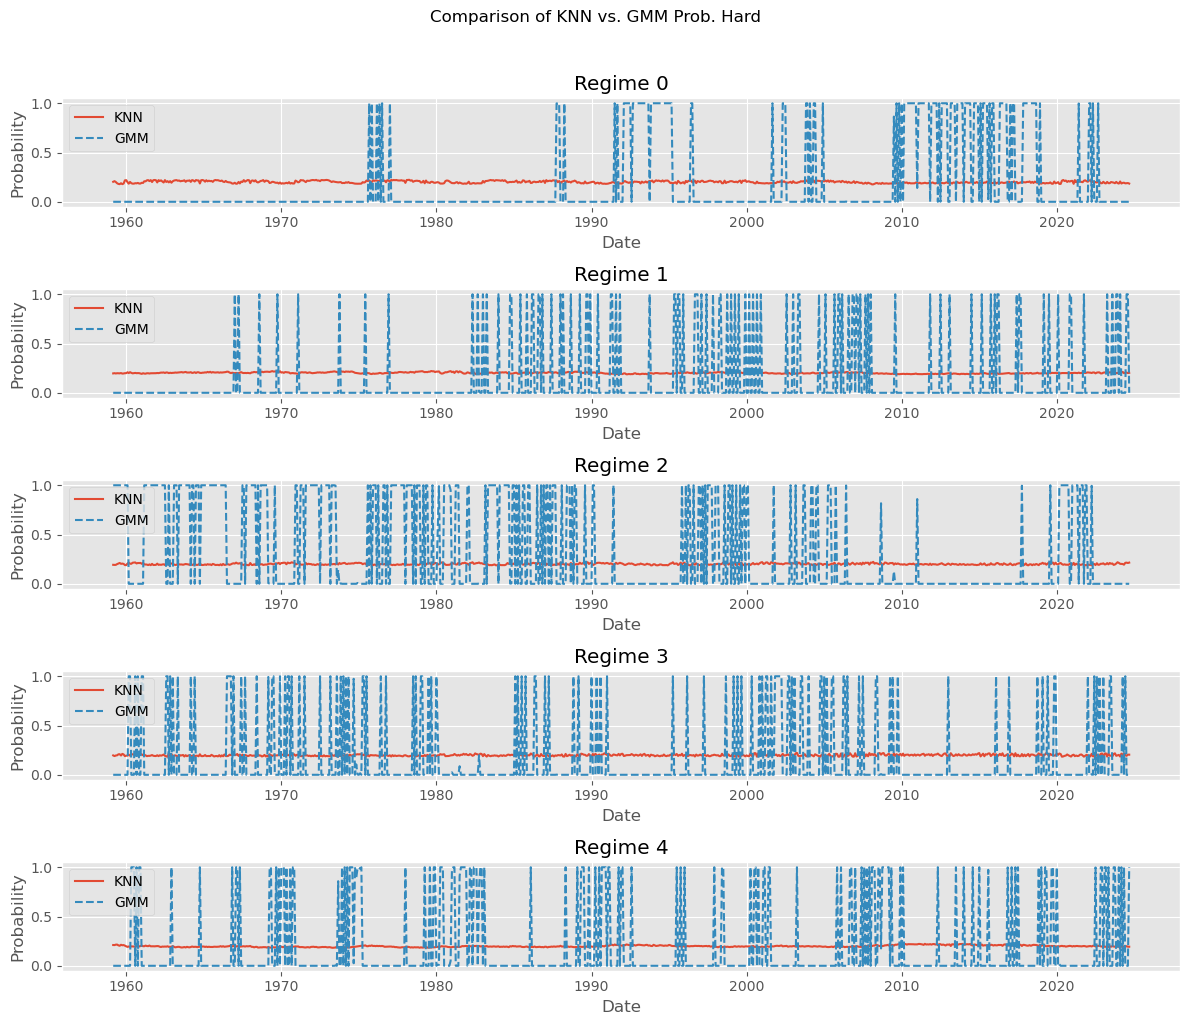

In [15]:
# Set the figure size and number of subplots for HARD probabilities comparison
fig, axes = plt.subplots(len(knn_hard_probs_df.columns), 1, figsize=(12, 2 * len(knn_hard_probs_df.columns)))
fig.suptitle("Comparison of KNN vs. GMM Prob. Hard", y=1.02)

for i, feature in enumerate(knn_hard_probs_df.columns):
    ax = axes[i]
    ax.plot(knn_hard_probs_df.index, knn_hard_probs_df[feature], label="KNN")
    ax.plot(gmm_hard_probs_df.index, gmm_hard_probs_df[feature], label="GMM", linestyle="--")
    ax.set_title(f"Regime {feature}")
    ax.legend(loc="upper left")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Date")

plt.tight_layout()
plt.show()